## Evaluation of clustering (shape-based)

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from collections import defaultdict
from multiprocessing import cpu_count

import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["font.size"] = 15
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['axes.grid'] = True

import warnings
warnings.filterwarnings('ignore')

In [3]:
import sys
sys.path.append('../')
from tsdr import tsdr
from eval import groundtruth
from meltria import loader

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [ ]:
metrics_files = !find /datasets/argowf-chaos-rq54b/ -type f -name "*.json" | tail -n1
dataset_generator = loader.load_dataset_as_generator(metrics_files, target_metric_types={
        "containers": True,
        "services": True,
        "nodes": True,
        "middlewares": True,
    },
    num_datapoints=120,
)
records = [r for rec in dataset_generator for r in rec]

In [ ]:
record = records[0]
reducer = tsdr.Tsdr("residual_integral", **{
    "step1_residual_integral_threshold": 20,
    "step1_residual_integral_change_start_point": False,
    "step1_residual_integral_change_start_point_n_sigma": 3,
    "step2_clustering_method_name": "dbscan",
    "step2_dbscan_min_pts": 2,
    "step2_dbscan_dist_type": 'sbd',
    "step2_dbscan_algorithm": 'hdbscan',
    "step2_clustering_series_type": 'raw',
    "step2_clustering_choice_method": 'medoid',
})
tsdr_stat, clustering_info, anomaly_points = reducer.run(
    X=record.data_df,
    pk=record.pk,
    max_workers=cpu_count(),
)
reduced_df = tsdr_stat[-1][0]
anomalous_metrics_df = tsdr_stat[-2][0]

In [ ]:
cause_service: str = record.pk.get_service_by_container(record.chaos_comp())
grouped_metrics_by_service = record.pk.group_metrics_by_service(list(anomalous_metrics_df.columns))
cause_service_metrics: list[str] = grouped_metrics_by_service[cause_service]
anomalous_cause_service_metrics_df = anomalous_metrics_df[cause_service_metrics]
anomalous_cause_service_metrics_df.shape

In [4]:
import datetime
import jsonlines
import glob

import ipywidgets as widgets

### DTW + KNN

In [5]:
from sklearn.neighbors import NearestNeighbors
from tslearn.neighbors import KNeighborsTimeSeries
from tslearn.metrics import dtw

In [ ]:
# import scipy.interpolate

# NUM_DATAPOINTS = 120

# def interp1d(_ts: np.ndarray) -> np.ndarray:
#     ts = _ts[~np.isnan(_ts)]
#     return scipy.interpolate.interp1d(
#         x=np.arange(NUM_DATAPOINTS - len(ts), NUM_DATAPOINTS), y=ts, kind="cubic", fill_value="extrapolate",
#     )(np.arange(0, NUM_DATAPOINTS))

In [6]:
from tsdr.clustering.sbd import sbd

def build_clustered_metrics(X: pd.DataFrame, k: int = 5):
    # remove metrics that have nan.
    # _ts = ts.apply(lambda x: pd.Series(interp1d(x.to_numpy())), axis=0)
    _X = X.loc[:, X.apply(lambda x: not x.isna().any())]
    # def distance(x, y) -> float:
    #     return fastdtw(x, y)[0]
    nbrs = NearestNeighbors(n_neighbors=k, metric=dtw).fit(_X.values.T)
    idx_arrays = nbrs.kneighbors(return_distance=False)
    return [_X.columns[idx].to_list() for idx in idx_arrays]

def find_similar_metrics(X: pd.DataFrame, col: str, k: int = 5) -> pd.DataFrame:
    base_x = X.loc[:, col].to_numpy()
    _X: pd.DataFrame = X.loc[:, X.columns!=col]
    topk = _X.agg(lambda y: dtw(base_x, y.to_numpy())).T.sort_values().head(k)
    return _X[topk.index]

def find_similar_metrics_with_sbd(X: pd.DataFrame, col: str, k: int = 5) -> tuple[pd.DataFrame, pd.Series]:
    base_x = X.loc[:, col].to_numpy()
    _X: pd.DataFrame = X.loc[:, X.columns!=col]
    topk = _X.agg(lambda y: sbd(scipy.stats.zscore(base_x, nan_policy="omit"), scipy.stats.zscore(y.to_numpy(), nan_policy="omit"))).T.sort_values().head(k)
    return _X[topk.index], topk

In [ ]:
clustered_metrics = build_clustered_metrics(anomalous_cause_service_metrics_df)
clustered_metrics

In [ ]:
len(clustered_metrics)

In [ ]:
import math
import scipy.interpolate

# interpolated_anomalous_cause_service_metrics_df = anomalous_cause_service_metrics_df.interpolate(method='spline', order=2, axis=0, limit_direction="both")
num_datapoints = anomalous_cause_service_metrics_df.shape[0]
plt.rcParams["font.size"] = 9

for metrics in clustered_metrics[:3]:
    fig = plt.figure(figsize=(20, 12))
    axs = fig.subplots(math.ceil(len(metrics)/3), 3)
    for ax, metric in zip(axs.flatten(), metrics):
        ts = anomalous_cause_service_metrics_df[metric].to_numpy()
        zts = scipy.stats.zscore(ts, nan_policy="omit")
        ax.plot(range(ts.size), zts)
        # ax.plot(scipy.stats.zscore(ts, nan_policy="omit"))
        ax.set_title(metric)

In [ ]:
similar_metrics = find_similar_metrics(anomalous_cause_service_metrics_df, "c-ts-user-mongo_memory_usage_bytes")
similar_metrics

## Sampling from full datasets

In [7]:
# Loading reduced metrics data

import pathlib
import pickle
import random
from collections import defaultdict

NUM_SAMPLES_BY_CHAOS_TYPE: int = 5

def load_tsdr():
    results = []
    parent_path = pathlib.Path(f"../data/tsdr_rq54b")
    for path in parent_path.iterdir():
        with (path / "record.pkl").open("rb") as f:
            record = pickle.load(f)
        with (path / "reduced_df.pkl").open("rb") as f:
            reduced_df = pickle.load(f)
        with (path / "no_clustering_reduced_df.pkl").open("rb") as f:
            no_clustering_reduced_df = pickle.load(f)
        results.append((record, reduced_df, no_clustering_reduced_df))
    return results

datasets = load_tsdr()

In [8]:
well_injected_fault_dataset_entries_texts: list[str] = """
ts-food-service/pod-memory-hog/0
ts-travel2-service/pod-memory-hog/0
ts-consign-mongo/pod-cpu-hog/0
ts-travel2-mongo/pod-network-loss/0
ts-train-mongo/pod-network-loss/0
ts-station-service/pod-cpu-hog/0
ts-auth-mongo/pod-memory-hog/0
ts-user-service/pod-network-loss/0
ts-travel-service/pod-memory-hog/0
ts-order-other-service/pod-network-loss/0
ts-food-mongo/pod-cpu-hog/0
ts-train-service/pod-network-loss/0
ts-price-service/pod-network-loss/0
ts-order-service/pod-cpu-hog/0
ts-auth-mongo/pod-cpu-hog/0
ts-train-service/pod-cpu-hog/0
ts-auth-service/pod-memory-hog/0
ts-order-service/pod-network-loss/0
ts-travel-mongo/pod-network-loss/0
ts-basic-service/pod-memory-hog/0
ts-station-service/pod-network-loss/0
ts-basic-service/pod-cpu-hog/0
ts-order-mongo/pod-memory-hog/0
ts-food-mongo/pod-network-loss/0
ts-user-service/pod-memory-hog/0
ts-order-mongo/pod-cpu-hog/0
ts-travel2-service/pod-network-loss/0
ts-station-mongo/pod-cpu-hog/0
ts-auth-mongo/pod-network-loss/0
ts-food-mongo/pod-memory-hog/0
ts-price-mongo/pod-network-loss/0
ts-basic-service/pod-network-loss/0
ts-order-service/pod-memory-hog/0
ts-food-service/pod-cpu-hog/0
ts-auth-service/pod-network-loss/0
ts-station-mongo/pod-network-loss/0
ts-train-service/pod-memory-hog/0
ts-travel-service/pod-network-loss/0
ts-order-mongo/pod-network-loss/0
ts-order-other-service/pod-memory-hog/0
ts-consign-mongo/pod-memory-hog/0
ts-train-mongo/pod-memory-hog/0
ts-travel-service/pod-cpu-hog/0
ts-preserve-service/pod-memory-hog/0
ts-auth-service/pod-cpu-hog/0
ts-station-service/pod-memory-hog/0
""".splitlines()
well_injected_fault_dataset_entries: list[tuple[str, str]] = [
    tuple(line.rstrip("/0").split("/")) for line in well_injected_fault_dataset_entries_texts
][1:]

well_injected_fault_datasets = [(record, reduced_df, no_clustering_reduced_df) for record, reduced_df, no_clustering_reduced_df in datasets if (record.chaos_comp(), record.chaos_type()) in well_injected_fault_dataset_entries]

1: ts-food-service/pod-memory-hog/0
2: ts-travel2-service/pod-memory-hog/0
3: ts-consign-mongo/pod-cpu-hog/0
4: ts-travel2-mongo/pod-network-loss/0
5: ts-user-mongo/pod-network-loss/0
6: ts-travel2-service/pod-cpu-hog/0
7: ts-station-mongo/pod-memory-hog/0
8: ts-payment-service/pod-cpu-hog/0
9: ts-train-mongo/pod-network-loss/0
10: ts-price-mongo/pod-memory-hog/0
11: ts-cancel-service/pod-memory-hog/0
12: ts-preserve-service/pod-cpu-hog/0
13: ts-payment-service/pod-network-loss/0
14: ts-station-service/pod-cpu-hog/0
15: ts-travel-mongo/pod-memory-hog/0
16: ts-auth-mongo/pod-memory-hog/0
17: ts-user-service/pod-network-loss/0
18: ts-food-service/pod-network-loss/0
19: ts-travel-service/pod-memory-hog/0
20: ts-payment-mongo/pod-network-loss/0
21: ts-travel2-mongo/pod-cpu-hog/0
22: ts-order-other-service/pod-network-loss/0
23: ts-food-mongo/pod-cpu-hog/0
24: ts-train-service/pod-network-loss/0
25: ts-price-service/pod-network-loss/0
26: ts-order-service/pod-cpu-hog/0
27: ts-auth-mongo/pod

<Figure size 2000x5000 with 0 Axes>

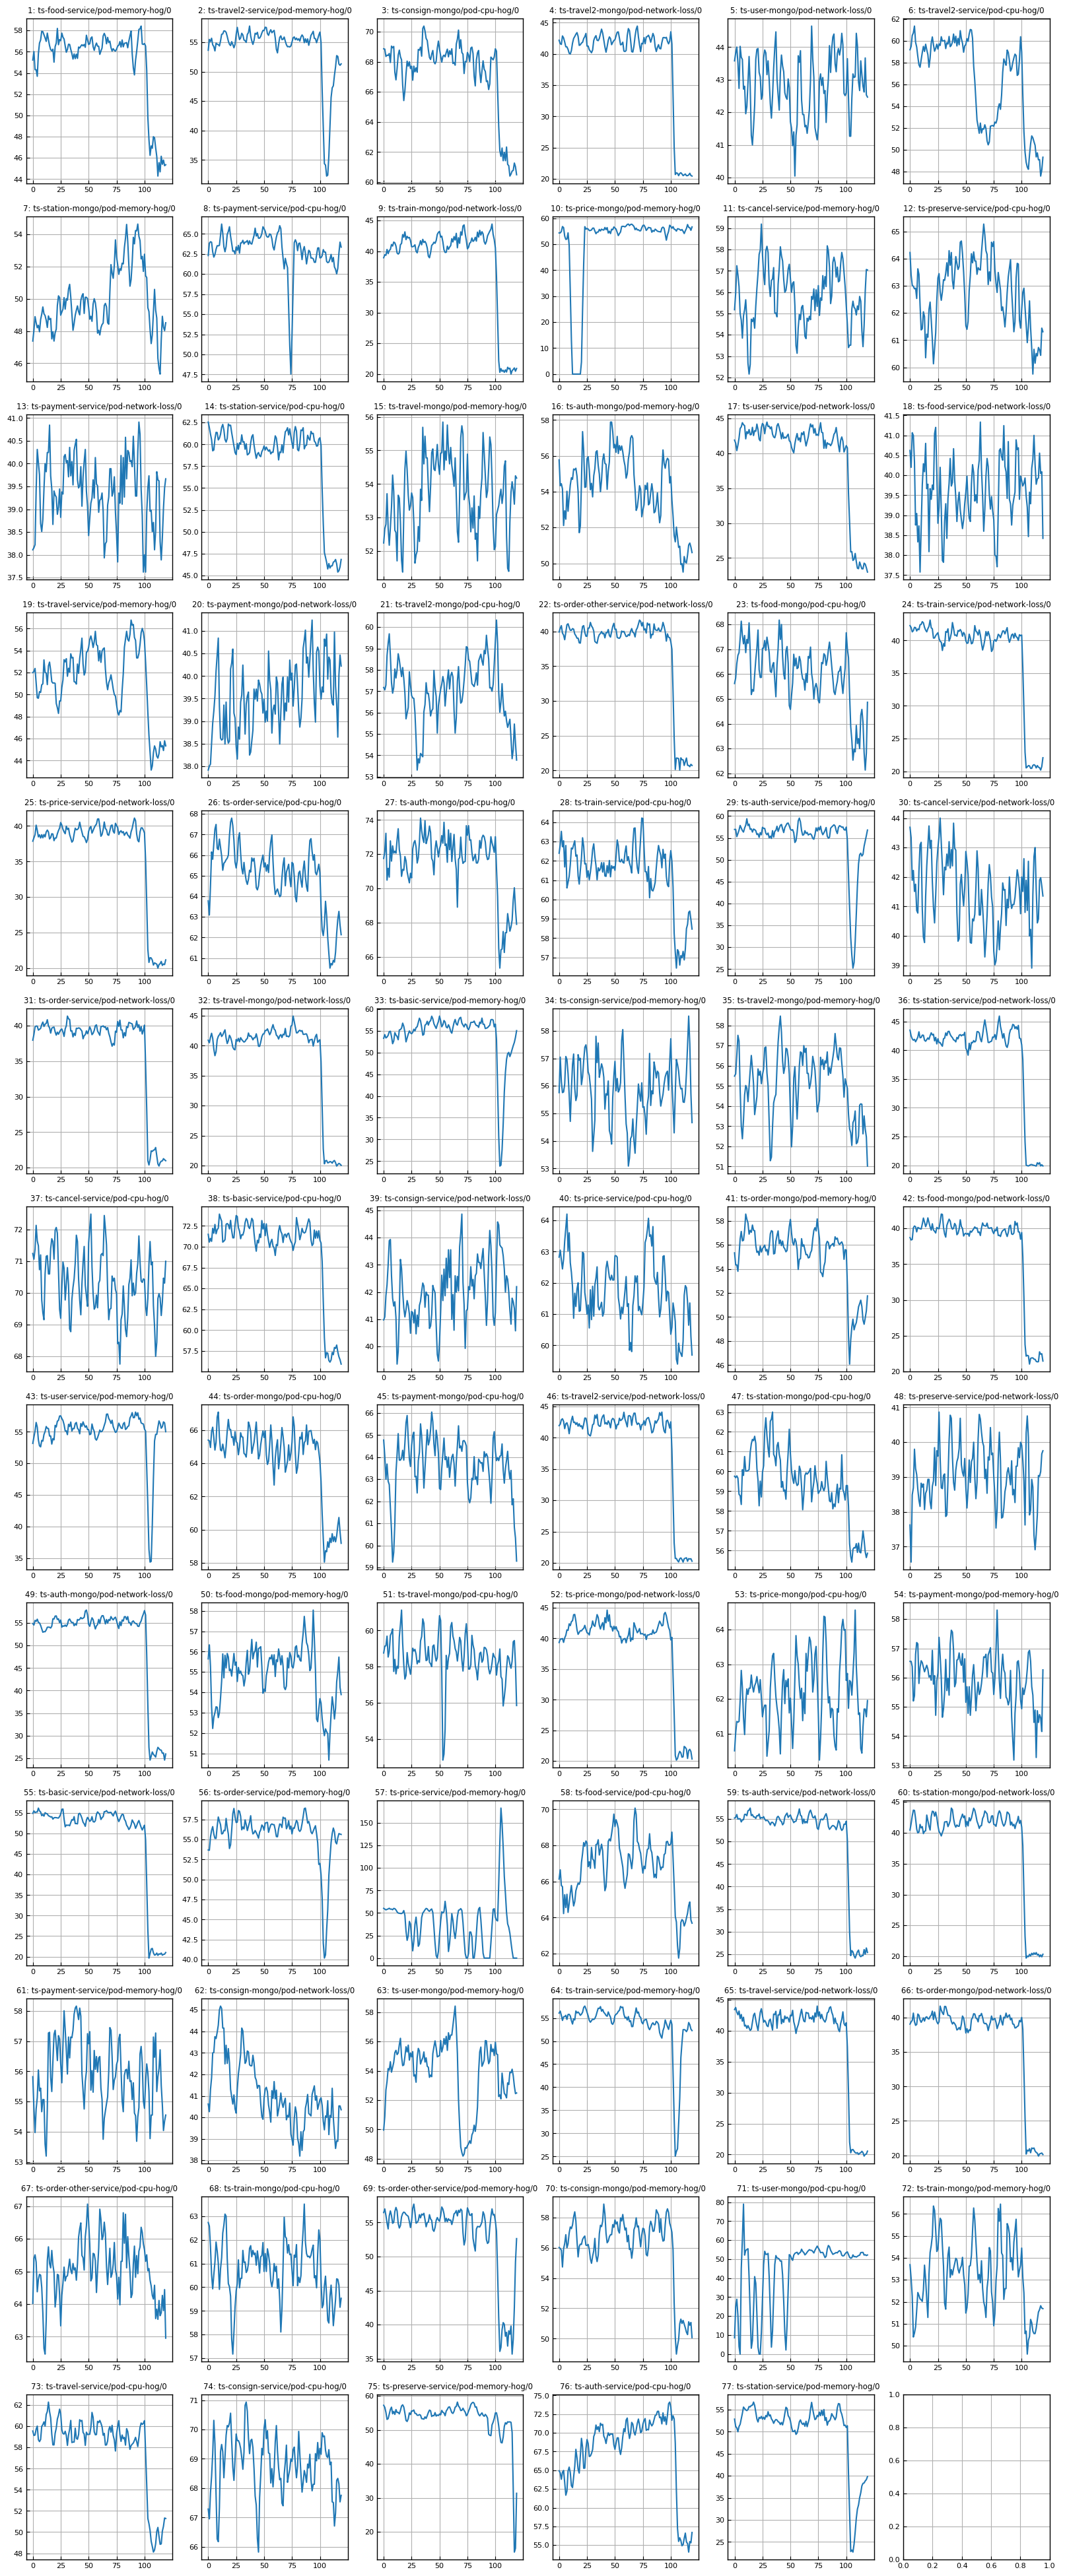

In [81]:
import math

plt.rcParams["font.size"] = 7
slis_fig = plt.figure(figsize=(20, 50))
slis_fig, slis_axs = plt.subplots(math.ceil(len(datasets)/6), 6, figsize=(20, 50))
for i, (slis_ax, (record, _, _)) in enumerate(zip(slis_axs.flatten(), datasets)):
    slis_ax.plot(record.data_df["m-ts-ui-dashboard_nginx_http_response_count_total"].to_numpy())
    title = f"{i+1}: {record.chaos_case_full()}"
    slis_ax.set_title(title)
    print(title)

In [9]:
samples_by_chaos_type: dict = defaultdict(list)
for record, _, anomalous_metrics_df in well_injected_fault_datasets:
    cause_service: str = record.pk.get_service_by_container(record.chaos_comp())
    grouped_metrics_by_service = record.pk.group_metrics_by_service(list(anomalous_metrics_df.columns))
    cause_service_metrics: list[str] = grouped_metrics_by_service[cause_service]
    anomalous_cause_service_metrics_df = anomalous_metrics_df[cause_service_metrics]
    samples_by_chaos_type[record.chaos_type()].append((record, anomalous_cause_service_metrics_df))

record_and_anomalous_cause_service_metrics_df = []
for chaos_type, samples in samples_by_chaos_type.items():
    if chaos_type == "pod-memory-hog":
        pass
    elif chaos_type == "pod-cpu-hog":
        samples = [
            (record, df) for (record, df) in samples
            if record.chaos_comp not in [
                "ts-train-service",
                "ts-food-service",
            ]
        ]
        for sample in random.sample(samples, k=3):
            record_and_anomalous_cause_service_metrics_df.append(sample)
    else:
        for sample in random.sample(samples, k=NUM_SAMPLES_BY_CHAOS_TYPE):
            record_and_anomalous_cause_service_metrics_df.append(sample)

In [10]:
from dataclasses import dataclass

@dataclass(frozen=True)
class TSWindow:
    total_records: int
    current_record_no: int
    record: loader.DatasetRecord
    total_metrics_in_current_record: int
    current_metrics_no_in_current_record: int
    current_metric: str
    current_metric_ts: np.ndarray
    sli_metric_ts: np.ndarray
    sli_metric: str
    similar_metrics_df: pd.DataFrame
    similar_metrics_top_score: pd.Series
    
    def current_pos_info(self) -> str:
        return f"{self.current_record_no}/{self.total_records}:{self.record.chaos_case_full()} -> {self.current_metrics_no_in_current_record}/{self.total_metrics_in_current_record}"

In [12]:
def create_widget_for_clustering(yield_on_click, num_similar_metrics: int = 10) -> widgets.Box:
    save_button = widgets.Button(description='Save')
    skip_button = widgets.Button(description='Skip')
    select_pattern = widgets.Select(
        options=[
            'Sudden increase', 'Sudden decrease', 'Level shift up', 'Level shift down', 
            'Steady increase', 'Steady decrease', 'Single spike', 'Single dip',
            'Transient level shift up', 'Transient level shift down', 'Multiple spikes', 'Multiple dips', 'Fluctuations',
            'White noise', 'Other normal',
        ],
        rows=15,
        layout=widgets.Layout(width='20%'),
    )
    select_position = widgets.Select(
        options=["no_anomaly", "anomaly_during_fault", "anomaly_outside_fault"],
        layout=widgets.Layout(width='15%'),
    )
    select_similar_metrics = widgets.SelectMultiple(
        options=[],
        rows=num_similar_metrics+2,
        disabled=False,
        layout=widgets.Layout(width='40%'),
    )
    msg_output = widgets.Output(layout={'border': '1px solid black'})
    fig_output = widgets.Output(layout={'border': '1px solid black'})
    log_output = widgets.Output(layout={'border': '1px solid black'})

    plt.rcParams["font.size"] = 6
    plt.rcParams['xtick.labelsize'] = 8
    plt.rcParams['ytick.labelsize'] = 8
    fig1, cur_and_sli_axs = plt.subplots(1, 2, figsize=(8, 1.5), clear=True)
    fig2, similar_axs = plt.subplots(2, num_similar_metrics//2, figsize=(20, 5), clear=True)

    def show() -> None:
        tsw: TSWindow = next(yield_on_click)
        with msg_output:
            msg_output.clear_output(wait=True)
            display(tsw.current_pos_info())

        cur_ax, sli_ax = cur_and_sli_axs[0], cur_and_sli_axs[1]
        cur_ax.clear()
        cur_ax.set_title(tsw.current_metric)
        cur_ax.plot(tsw.current_metric_ts)

        sli_ax.clear()
        sli_ax.plot(tsw.sli_metric_ts)
        sli_ax.set_title(f"SLI")
        for _ax in cur_and_sli_axs:
            _ax.axvspan(100, tsw.current_metric_ts.size, color='red', alpha=0.5)
        for i, (_ax, metric) in enumerate(zip(similar_axs.flatten(), tsw.similar_metrics_df.columns)):
            _ax.clear()
            _ax.plot(tsw.similar_metrics_df.loc[:, metric])
            _ax.set_title(f"{i+1}: {metric}")
            _ax.axvspan(100, tsw.current_metric_ts.size, color='red', alpha=0.5)
        with fig_output:
            fig_output.clear_output(wait=True)
            display(fig1)
            display(fig2)
        
        with log_output:
            log_output.clear_output(wait=True)
            display(tsw.similar_metrics_top_score)

        select_similar_metrics.options = tsw.similar_metrics_df.columns.tolist()

    def on_save_click_callback(clicked_button: widgets.Button) -> None:
        yield_on_click.send(((select_position.value, select_pattern.value), select_similar_metrics.value))
        with msg_output:
            msg_output.clear_output(wait=True)
            display(f"Selected {select_pattern.value} and {select_position.value}!")
        show()

    save_button.on_click(on_save_click_callback)
    plt.close(fig=fig1)
    plt.close(fig=fig2)
    show()

    def on_skip_click_callback(clicked_button: widgets.Button) -> None:
        with msg_output:
            msg_output.clear_output(wait=True)
            display(f"Skipped")
        show()

    skip_button.on_click(on_skip_click_callback)

    return widgets.VBox([
        msg_output,
        fig_output,
        widgets.HBox([
            select_pattern,
            select_position,
            select_similar_metrics,
            widgets.VBox([save_button, skip_button])
        ]),
        log_output,
    ])

In [13]:
import re

RANGE_VECTOR_DURATION = 60
PER_MINUTE_NUM: int = int(RANGE_VECTOR_DURATION / 15) + 1

JVM_TOMCAT_PATTERN: re.Pattern = re.compile(
    r"^Tomcat_.+_(requestCount|maxTime|processingTime|requestProcessingTime|errorCount|[b|B]ytesSent|[b|B]ytesReceived)$"
)
JVM_OS_PATTERN: re.Pattern = re.compile(r"^java_lang_OperatingSystem_.+_ProcessCpuTime$")
JVM_JAVA_PATTERN: re.Pattern = re.compile(r"^java_lang_.+[t|T]ime$")

MONGODB_EXCLUDE_PATTERN: re.Pattern = re.compile(
    r"^mongodb_.+_([kb|mb|gb|time_ms])$"
)


def rate_of_metrics(ts: np.ndarray) -> np.ndarray:
    slides = np.lib.stride_tricks.sliding_window_view(ts, PER_MINUTE_NUM)
    rate = (np.max(slides, axis=1).reshape(-1) - np.min(slides, axis=1).reshape(-1)) / RANGE_VECTOR_DURATION
    first_val = rate[0]
    for _ in range(PER_MINUTE_NUM - 1):
        rate = np.insert(rate, 0, first_val)  # backfill
    return rate


def should_not_rate_metrics(x: np.ndarray) -> bool:
    return bool(
        np.all(x == x[0])             # check all values are the same
        or np.any(np.diff(x) < 0)     # check not monotonic increasing
        or np.any(x != np.round(x))  # check including float because a counter metric should be integer.
    )


def rate_of_metrics_with_check(metric: str, ts: np.ndarray) -> np.ndarray:
    if not metric.startswith("m-"):
        return ts

    metric_comp, metric_base_name = metric.split("-", maxsplit=1)[1].split("_", maxsplit=1)

    if should_not_rate_metrics(ts):
        return ts

    if MONGODB_EXCLUDE_PATTERN.match(metric_base_name):
        return ts

    if (
        JVM_JAVA_PATTERN.match(metric_base_name)
        or JVM_OS_PATTERN.match(metric_base_name)
        or JVM_TOMCAT_PATTERN.match(metric_base_name)
    ):
        # work around rate_of_metrics(ts)
        return ts

    return rate_of_metrics(ts)

In [14]:
import os

SAVE_DIR = "../samples/clustering_anomaly_patterns"

def gen_time_series_similar(
    record_and_anomalous_df: list[tuple[loader.DatasetRecord, pd.DataFrame]],
    time: str = datetime.datetime.today().strftime('%Y%m%d-%H%M%S'),
):
    save_file_name = f"{SAVE_DIR}/clustering_anomaly_patterns_{time}.jsonl"

    for i, (record, anomalous_df) in enumerate(record_and_anomalous_df):
        anomalous_metrics_df = anomalous_df.copy(deep=True).apply(
            lambda x: pd.Series(rate_of_metrics_with_check(x.name, x.to_numpy())
        ), axis=0)
        anomalous_metrics_df.interpolate(method="bfill", inplace=True)
        anomalous_metrics_df.interpolate(method="ffill", inplace=True)
        anomalous_metrics_df = anomalous_metrics_df.loc[:, anomalous_metrics_df.apply(lambda x: np.isnan(x).sum() <= 20, axis=0)]

        sli_metric: str = "m-ts-ui-dashboard_nginx_http_response_count_total"
        sli_ts = record.data_df.loc[:, sli_metric].to_numpy()
        labeled_metrics_list: list[str] = []
        total_num_metrics = anomalous_metrics_df.shape[1]
        for current_metric in anomalous_metrics_df.columns.tolist():
            if current_metric in labeled_metrics_list:
                continue

            similar_metrics_df, top_score = find_similar_metrics_with_sbd(
                anomalous_metrics_df, current_metric, k=10)

            tsw = TSWindow(
                total_records=len(record_and_anomalous_df),
                current_record_no=i+1,
                record=record,
                total_metrics_in_current_record=total_num_metrics,
                current_metric=current_metric,
                current_metric_ts=anomalous_metrics_df.loc[:, current_metric].to_numpy(),
                current_metrics_no_in_current_record=len(labeled_metrics_list),
                sli_metric_ts=sli_ts,
                sli_metric=sli_metric,
                similar_metrics_df=similar_metrics_df,
                similar_metrics_top_score=top_score,
            )

            # Sent tsw to the UI widget's callback
            v = (yield tsw)
            if v is None:
                continue
            ((position, pattern_name), similar_metrics) = v

            with jsonlines.open(save_file_name, mode='a', flush=True) as writer:
                for _metric in [current_metric] + list(similar_metrics):
                    writer.write({
                        'target_app': record.target_app(), 
                        'chaos_type': record.chaos_type(),
                        'chaos_comp': record.chaos_comp(), 
                        'metric': _metric,
                        'anomaly_position': position,
                        'anomaly_pattern': pattern_name,
                        'time_series': anomalous_metrics_df.loc[:, _metric].to_numpy().tolist(),
                    })
                    labeled_metrics_list.append(_metric)
                    anomalous_metrics_df.drop(columns=_metric, inplace=True)

In [15]:
box = create_widget_for_clustering(
    gen_time_series_similar(record_and_anomalous_cause_service_metrics_df, time="20221030-162851")
)
display(box)